In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# ----------------------------------------
# CONFIGURATION
# ----------------------------------------
from google.colab import drive
drive.mount('/content/drive')
PEDESTRIAN_FILE = '/content/drive/MyDrive/Frankfurt Data/Pedestrian_Coordinates.txt'
PLATFORM_FILE = '/content/drive/MyDrive/Frankfurt Data/Platform_Design_Coordinates.txt'
FRAME_RATE = 4  # 4 frames per second

# ----------------------------------------
# LOAD AND CLEAN PEDESTRIAN DATA
# ----------------------------------------
# Skip metadata lines starting with '#'
# Load the full pedestrian data
df = pd.read_csv(PEDESTRIAN_FILE, comment='#', delim_whitespace=True,
                          names=['id', 'frame', 'x', 'y', 'z'])

import warnings
warnings.filterwarnings("ignore")



Mounted at /content/drive


/tmp/ipython-input-1-2504384769.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(PEDESTRIAN_FILE, comment='#', delim_whitespace=True,


##### 🚆 Notebook Summary: Passenger Behavior and Train Door Analysis
##### 1. Initial Approach: Static Time Window and Fixed Measurement Line
##### - Selected a small time window from 8:00 AM to 8:30 AM to begin the analysis.
##### - Used a static measurement line placed 1.5 meters from the platform edge (Y = -3.77), i.e., at Y = -2.27.
##### - Observation: This static line failed to capture all boarding/alighting passengers,
#####   as some passengers were located farther than 1.5 meters from the platform edge.

##### 2. Improved Approach: Combination of Static and Dynamic Thresholds
##### - Introduced a dynamic approach to better detect passenger movement across the platform.
##### - Also tested additional static thresholds: 1.5 m, 2.5 m, and 3.5 m from the edge.
##### - The dynamic method improved detection accuracy by adapting to the actual behavior of passengers.

##### 3. Crowd Behavior Identification
##### - Analyzed passenger density near the platform edge to identify:
#####   - Low crowd conditions: few passengers near the edge.
#####   - High crowd conditions: clusters of passengers, often indicating train arrivals or peak times.

##### 4. Generalized Function Tested on Multiple Time Scenarios
##### - Developed a complete function to automate classification, door assignment, and dwell time analysis.
##### - Tested the function on three distinct time frames:
#####   1. High Crowd Period: 6:30 AM to 10:00 AM
#####   2. High Crowd Period: 4:30 PM to 7:00 PM
#####   3. Low Crowd Period: 1:00 AM to 4:30 AM


# 1. Initial Approach: Static Time Window and Fixed Measurement Line

In [67]:
# Parameters
# Filters pedestrian movement data to only consider activity between 8:00 and 8:30 AM.
# Identifies passengers with movement (i.e., whose Y-position changes).

# Classifies passengers into the upper or lower platform based on their Y-coordinate.

# Focuses on passengers on the lower platform and applies a sliding window approach (1-minute intervals) to detect time windows when a train is likely present — indicated by a sudden increase in passengers near the platform edge.

# -----------------------------
FRAME_RATE = 4  # frames per second
# Platform coordinates
platform_y_min = -3.77

# Divide line
y_divide = 4.475

# Time range (8:00 to 8:30)
start_hour = 8
end_hour = 8.5
start_sec = start_hour * 3600
end_sec = end_hour * 3600

start_frame = int(start_sec * FRAME_RATE)
end_frame = int(end_sec * FRAME_RATE)

# -----------------------------
# Filter frames for 8:00 - 8:30
# -----------------------------
df_time = df[(df['frame'] >= start_frame) & (df['frame'] < end_frame)]

# -----------------------------
# Identify passengers moving toward or away from y = -3.77
# -----------------------------
filtered_ids = []

for pid, group in df_time.groupby('id'):
    y_start = group.iloc[0]['y']
    y_end = group.iloc[-1]['y']

    dist_start = abs(y_start - platform_y_min)
    dist_end = abs(y_end - platform_y_min)

    if dist_start != dist_end:
        filtered_ids.append(pid)

# Keep only those passengers
df_clean = df_time[df_time['id'].isin(filtered_ids)].copy()

# -----------------------------
# Add area column (upper or lower part of platform)
# -----------------------------
df_clean['platform_area'] = np.where(df_clean['y'] > y_divide, 'upper', 'lower')

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# -----------------------------
# Parameters
# -----------------------------
platform_edge_y = -3.77
edge_threshold_y = -2.0  # consider as 'near edge'
window_size_frames = 240  # 1 minute window (1 min * 60 sec * 4 fps)
passenger_threshold = 15  # adjust depending on your data

# -----------------------------
# Load cleaned data
# -----------------------------
# df_clean has clean data

# Only lower platform area
df_lower = df_clean[df_clean['platform_area'] == 'lower'].copy()

# -----------------------------
# Step 1: Identify train instances
# -----------------------------
min_frame = df_lower['frame'].min()
max_frame = df_lower['frame'].max()

train_instances = []
current_train_id = 1

for start in range(min_frame, max_frame, window_size_frames):
    end = start + window_size_frames
    window_df = df_lower[(df_lower['frame'] >= start) & (df_lower['frame'] < end)]
    edge_df = window_df[window_df['y'] < edge_threshold_y]

    num_passengers = edge_df['id'].nunique()

    if num_passengers >= passenger_threshold:
        train_instances.append({
            'train_id': current_train_id,
            'start_frame': start,
            'end_frame': end
        })
        current_train_id += 1

train_df = pd.DataFrame(train_instances)
print(train_df)

   train_id  start_frame  end_frame
0         1       116400     116640
1         2       117360     117600
2         3       118560     118800
3         4       119520     119760
4         5       120720     120960
5         6       122160     122400


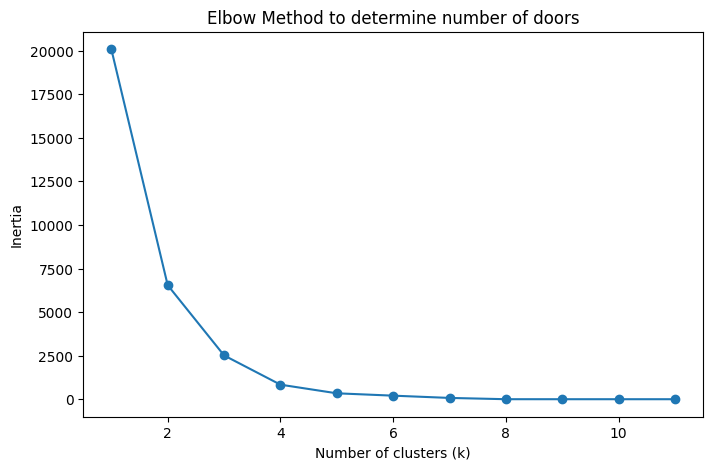

[20080.27545410526, 6542.712157411762, 2514.1605810833325, 835.7057759499393, 340.2427595396824, 205.14240593968242, 75.06772855164834, 1.594999895238097, 1.210435395238098, 0.8830566428571459, 0.648973309523814]


In [47]:
# -----------------------------
# Step 2: Pick one train instance
# -----------------------------
# From the previously detected list of train instances (`train_df`), we select one train to analyze in detail.
# Each train instance corresponds to a 1-minute window where a train is assumed to be present at the platform.
# We specify the train to analyze by setting `chosen_train_id`.
# This code retrieves the corresponding start and end frame range for that specific train.
# We then extract all pedestrian data (from the lower platform) that occurred during this time window.
chosen_train_id = 1  # You can change this
chosen_train = train_df[train_df['train_id'] == chosen_train_id].iloc[0]

start_frame = chosen_train['start_frame']
end_frame = chosen_train['end_frame']

chosen_df = df_lower[(df_lower['frame'] >= start_frame) & (df_lower['frame'] < end_frame)].copy()

# -----------------------------
# Step 3: Identify doors using elbow method
# -----------------------------
# During the selected time window, we expect passengers to gather near the train doors (at the edge of the platform).
# We use only those passengers whose Y-coordinate is below `edge_threshold_y`, which indicates they are near the edge.
# The idea is that each cluster in the X-coordinate represents a crowd near a train door.
# We apply the KMeans clustering algorithm on the X-coordinates of these passengers to group them spatially.
edge_chosen_df = chosen_df[chosen_df['y'] < edge_threshold_y].copy()
X = edge_chosen_df[['x']].to_numpy()

inertias = []
K_range = range(1, 12)
# We test a range of cluster counts (k = 1 to 12) and compute the "inertia" for each k.
# Inertia is the sum of squared distances from each point to its assigned cluster center.
# A lower inertia indicates tighter clusters.
# The "elbow" point in the inertia vs. k curve indicates the optimal number of clusters:
# — adding more clusters beyond this point yields only marginal improvement.
# — each cluster is interpreted as one potential train door position.

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to determine number of doors')
plt.show()

print(inertias)

Enter optimal number of doors (k) after checking plot: 5


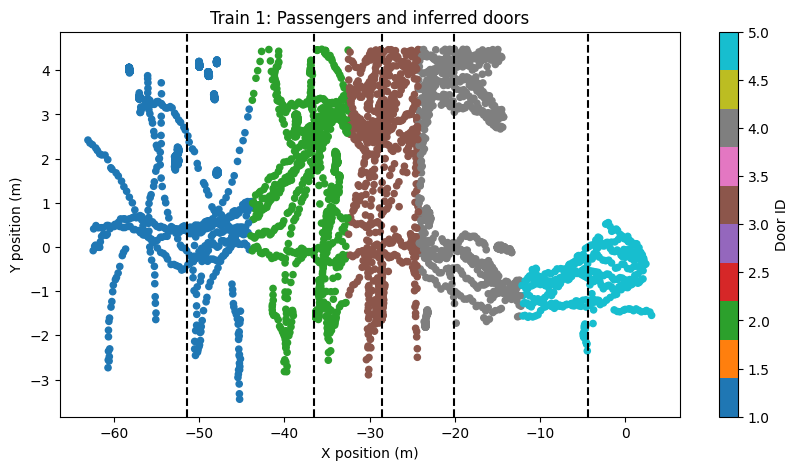

In [48]:
# -----------------------------
# Choose k manually after looking at elbow plot
# -----------------------------
optimal_k = int(input("Enter optimal number of doors (k) after checking plot: "))

kmeans_final = KMeans(n_clusters=optimal_k, random_state=0)
chosen_df['door_id'] = kmeans_final.fit_predict(chosen_df[['x']])

# Sort cluster centers so door IDs are ordered left to right
centers = kmeans_final.cluster_centers_.flatten()
sorted_idx = np.argsort(centers)

# Map cluster labels to ordered door IDs
label_map = {old_label: new_id+1 for new_id, old_label in enumerate(sorted_idx)}
chosen_df['door_id'] = chosen_df['door_id'].map(label_map)

# -----------------------------
# Plot result
# -----------------------------
plt.figure(figsize=(10, 5))
plt.scatter(chosen_df['x'], chosen_df['y'], c=chosen_df['door_id'], cmap='tab10', s=20)
for xc in sorted(centers):
    plt.axvline(xc, linestyle='--', color='k')
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
plt.title(f'Train {chosen_train_id}: Passengers and inferred doors')
plt.colorbar(label='Door ID')
plt.show()


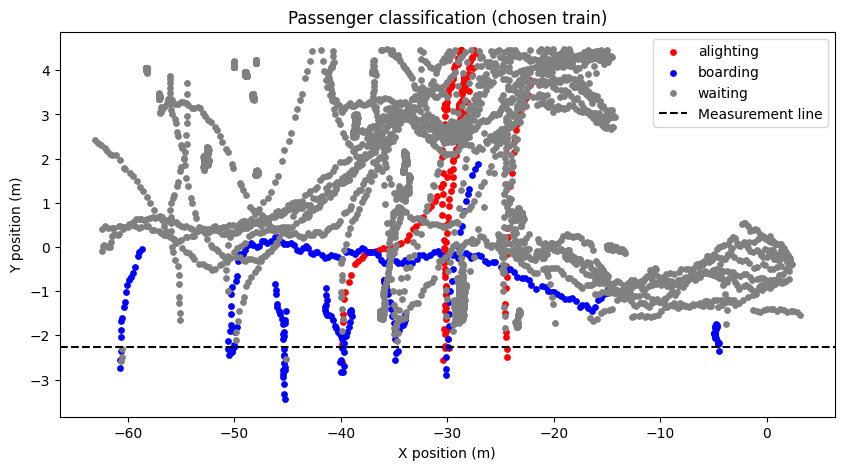

In [49]:
# This code processes pedestrian tracking data for a selected train instance to classify passenger behavior, analyze train door activity, and estimate dwell times. It also includes a visualization of the passenger categories. The steps are as follows:

# 🔹 Step 1: Classify Passengers as Boarding, Alighting, or Waiting
# The platform edge is defined at y = -3.77. A measurement line is placed slightly above this edge at y = -2.27 (i.e., 1.5 meters above the platform edge).
# For each unique passenger id in the selected train window:
# Their movement in the Y-direction is analyzed across time.
# If they cross the measurement line downward, they are labeled as boarding.
# If they cross it upward, they are labeled as alighting.
# If they do not cross it, they are considered waiting on the platform.
# 🔹 Step 2: Summarize Passenger Activity Per Door
# For each detected door location (door_id), the code:
# Filters passengers associated with that door.
# Counts how many boarded, alighted, or just waited near that door.
# Identifies the frame ranges during which boarding and/or alighting happened.
# Calculates dwell time (i.e., how long the door was actively used), based on the start and end frames of boarding/alighting.
# Time is converted from frames to seconds using a frame rate of 4 FPS.
# 🔹 Step 3: Visualize Passenger Behavior (Optional)
# Three cases are handled:
# Both boarding and alighting occur.
# Only boarding occurs.
# Only alighting occurs.
# Stores this information in a summary DataFrame.
# → The final summary_df_train_id_1 contains one row per door with:
# train_id, door_id, number of boarders, number of alighters, and calculated dwell_time_seconds.
# A scatter plot shows the spatial distribution of passengers (x, y) near the train during this instance.
# Passengers are colored by category:
# Blue: boarding
# Red: alighting
# Gray: waiting

# A dashed horizontal line marks the measurement line at y = -2.27.
# -----------------------------
# Parameters
# -----------------------------
measurement_line_y = -3.77 + 1.5  # => -2.27
chosen_train_id = 1  # already assigned in chosen_df_train_id_1
df_train_id_1 = chosen_df.copy()

# -----------------------------
# Step 1: Classify passengers
# -----------------------------
boarding_ids = set()
alighting_ids = set()
waiting_ids = set()

# Loop through each passenger
for pid in df_train_id_1['id'].unique():
    p_df_train_id_1 = df_train_id_1[df_train_id_1['id'] == pid].sort_values('frame')
    ys = p_df_train_id_1['y'].values

    # Check if passenger crosses the line
    crossed = False
    for i in range(1, len(ys)):
        prev_y = ys[i - 1]
        curr_y = ys[i]

        # Cross downward (boarding)
        if prev_y > measurement_line_y and curr_y <= measurement_line_y:
            boarding_ids.add(pid)
            crossed = True
            break
        # Cross upward (alighting)
        elif prev_y <= measurement_line_y and curr_y > measurement_line_y:
            alighting_ids.add(pid)
            crossed = True
            break

    if not crossed:
        waiting_ids.add(pid)

# Add category column
df_train_id_1['category'] = df_train_id_1['id'].apply(
    lambda x: 'boarding' if x in boarding_ids else ('alighting' if x in alighting_ids else 'waiting')
)

# -----------------------------
# Step 2: Create summary dataframe per door
# -----------------------------
summary_list = []

for door in sorted(df_train_id_1['door_id'].unique()):
    df_train_id_1_door = df_train_id_1[df_train_id_1['door_id'] == door]

    boarding_ids_door = set(df_train_id_1_door[df_train_id_1_door['category'] == 'boarding']['id'])
    alighting_ids_door = set(df_train_id_1_door[df_train_id_1_door['category'] == 'alighting']['id'])

    # Get boarding frames
    boarding_frames = df_train_id_1_door[df_train_id_1_door['id'].isin(boarding_ids_door)]['frame']
    alighting_frames = df_train_id_1_door[df_train_id_1_door['id'].isin(alighting_ids_door)]['frame']

    dwell_time_seconds = np.nan

    if not alighting_frames.empty and not boarding_frames.empty:
        # Case 1: both exist
        start_alighting = alighting_frames.min()
        end_boarding = boarding_frames.max()
        dwell_time_seconds = (end_boarding - start_alighting) / 4
    elif not boarding_frames.empty:
        # Case 2: only boarding
        start_boarding = boarding_frames.min()
        end_boarding = boarding_frames.max()
        dwell_time_seconds = (end_boarding - start_boarding) / 4
    elif not alighting_frames.empty:
        # Case 3: only alighting
        start_alighting = alighting_frames.min()
        end_alighting = alighting_frames.max()
        dwell_time_seconds = (end_alighting - start_alighting) / 4
    # Else, dwell_time_seconds remains NaN

    summary_list.append({
        'train_id': chosen_train_id,
        'door_id': door,
        'no_of_boarding': len(boarding_ids_door),
        'no_of_alighting': len(alighting_ids_door),
        'dwell_time_seconds': dwell_time_seconds
    })

summary_df_train_id_1 = pd.DataFrame(summary_list)



# -----------------------------
# Optional: Visualize categories for a door
# -----------------------------
plt.figure(figsize=(10, 5))
colors = {'boarding': 'blue', 'alighting': 'red', 'waiting': 'gray'}

for cat, group in df_train_id_1.groupby('category'):
    plt.scatter(group['x'], group['y'], label=cat, c=colors[cat], s=15)

plt.axhline(measurement_line_y, color='k', linestyle='--', label='Measurement line')
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
plt.title('Passenger classification (chosen train)')
plt.legend()
plt.show()


In [50]:
summary_df_train_id_1

,train_id,door_id,no_of_boarding,no_of_alighting,dwell_time_seconds
0,1,1,4,0,10.00
1,1,2,5,1,19.00
2,1,3,2,4,25.50
3,1,4,1,1,30.50
4,1,5,1,0,6.25


# 2. Improved Approach: Combination of Static and Dynamic Thresholds

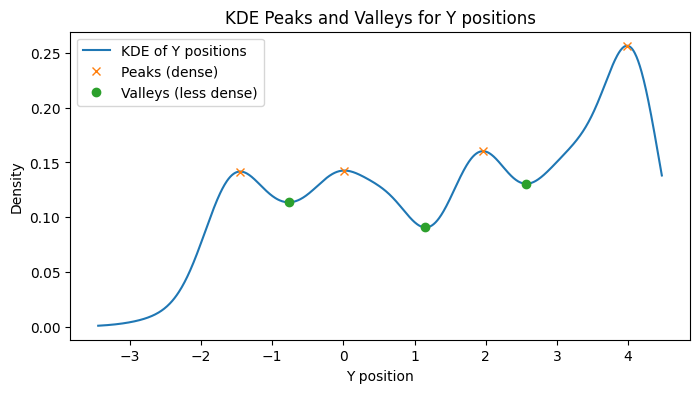

Dynamic measurement line set at y = -0.77


In [52]:

from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

# -----------------------------
# Parameters
# -----------------------------
chosen_train_id = 1  # already assigned in chosen_df_train_id_1
df_train_id_1 = chosen_df.copy()

# -----------------------------
# Step 1: Compute KDE of all y positions (combined passengers)
# -----------------------------
y_positions = df_train_id_1['y'].values

# Compute KDE
kde = gaussian_kde(y_positions)
y_grid = np.linspace(min(y_positions), max(y_positions), 1000)
kde_values = kde(y_grid)

# Find peaks (dense areas) and valleys (low density)
peaks, _ = find_peaks(kde_values)
valleys, _ = find_peaks(-kde_values)

# For visualization (optional)
plt.figure(figsize=(8, 4))
plt.plot(y_grid, kde_values, label='KDE of Y positions')
plt.plot(y_grid[peaks], kde_values[peaks], "x", label='Peaks (dense)')
plt.plot(y_grid[valleys], kde_values[valleys], "o", label='Valleys (less dense)')
plt.xlabel('Y position')
plt.ylabel('Density')
plt.legend()
plt.title('KDE Peaks and Valleys for Y positions')
plt.show()

# -----------------------------
# Step 2: Choose dynamic measurement line
# -----------------------------
# For example, choose the valley closest to your previous static measurement line y=-2.27
static_line = -2.27
valley_distances = np.abs(y_grid[valleys] - static_line)
closest_valley_idx = valleys[np.argmin(valley_distances)]
measurement_line_y = y_grid[closest_valley_idx]
print(f"Dynamic measurement line set at y = {measurement_line_y:.2f}")

# -----------------------------
# Step 3: Classify passengers using dynamic measurement line
# -----------------------------
boarding_ids = set()
alighting_ids = set()
waiting_ids = set()

for pid in df_train_id_1['id'].unique():
    p_df_train_id_1 = df_train_id_1[df_train_id_1['id'] == pid].sort_values('frame')
    ys = p_df_train_id_1['y'].values

    crossed = False
    for i in range(1, len(ys)):
        prev_y = ys[i - 1]
        curr_y = ys[i]

        # Cross downward (boarding)
        if prev_y > measurement_line_y and curr_y <= measurement_line_y:
            boarding_ids.add(pid)
            crossed = True
            break
        # Cross upward (alighting)
        elif prev_y <= measurement_line_y and curr_y > measurement_line_y:
            alighting_ids.add(pid)
            crossed = True
            break

    if not crossed:
        waiting_ids.add(pid)

df_train_id_1['category'] = df_train_id_1['id'].apply(
    lambda x: 'boarding' if x in boarding_ids else ('alighting' if x in alighting_ids else 'waiting')
)

# Now you can continue with your dwell time or other analyses


In [29]:
y_grid[peaks]

array([-1.44716216,  0.01157658,  1.96184685,  3.98346847])

In [30]:
y_grid[valleys]

array([-0.76536036,  1.1531982 ,  2.5722973 ])

In [53]:
# -----------------------------
# Step 2: Filter and select multiple valid measurement lines
# -----------------------------
platform_start_y = -3.77
threshold_distance = 4.0 # max distance allowed from platform edge for a measurement line

# Filter valleys close to platform edge ( taken static plus dynamic values)
valid_valleys = [y for y in y_grid[valleys] if np.abs(y - platform_start_y) <= threshold_distance] + [-3.77+ 1, -3.77+2]

# Sort them if needed
valid_valleys = sorted(valid_valleys)

print("Valid measurement lines (M-lines):", valid_valleys)

# -----------------------------
# Step 3: Classify passengers using valid measurement lines
# -----------------------------
boarding_ids = set()
alighting_ids = set()
waiting_ids = set()

for pid in df_train_id_1['id'].unique():
    p_df = df_train_id_1[df_train_id_1['id'] == pid].sort_values('frame')
    ys = p_df['y'].values

    crossed = False
    for i in range(1, len(ys)):
        prev_y = ys[i - 1]
        curr_y = ys[i]

        for m_line in valid_valleys:
            # Cross downward (boarding)
            if prev_y > m_line and curr_y <= m_line:
                boarding_ids.add(pid)
                crossed = True
                break
            # Cross upward (alighting)
            elif prev_y <= m_line and curr_y > m_line:
                alighting_ids.add(pid)
                crossed = True
                break
        if crossed:
            break

    if not crossed:
        waiting_ids.add(pid)

df_train_id_1['category'] = df_train_id_1['id'].apply(
    lambda x: 'boarding' if x in boarding_ids else ('alighting' if x in alighting_ids else 'waiting')
)


Valid measurement lines (M-lines): [-2.77, -1.77, np.float64(-0.76536036036036)]


In [9]:
valid_valleys

[-2.77, -1.77, -0.77, np.float64(-0.76536036036036)]

In [54]:
# -----------------------------
# Step 2: Create summary dataframe per door
# -----------------------------
summary_list = []

for door in sorted(df_train_id_1['door_id'].unique()):
    df_train_id_1_door = df_train_id_1[df_train_id_1['door_id'] == door]

    boarding_ids_door = set(df_train_id_1_door[df_train_id_1_door['category'] == 'boarding']['id'])
    alighting_ids_door = set(df_train_id_1_door[df_train_id_1_door['category'] == 'alighting']['id'])

    # Get boarding frames
    boarding_frames = df_train_id_1_door[df_train_id_1_door['id'].isin(boarding_ids_door)]['frame']
    alighting_frames = df_train_id_1_door[df_train_id_1_door['id'].isin(alighting_ids_door)]['frame']

    dwell_time_seconds = np.nan

    if not alighting_frames.empty and not boarding_frames.empty:
        # Case 1: both exist
        start_alighting = alighting_frames.min()
        end_boarding = boarding_frames.max()
        dwell_time_seconds = (end_boarding - start_alighting) / 4
        if dwell_time_seconds < 0:
            dwell_time_seconds = np.nan
    elif not boarding_frames.empty:
        # Case 2: only boarding
        start_boarding = boarding_frames.min()
        end_boarding = boarding_frames.max()
        dwell_time_seconds = (end_boarding - start_boarding) / 4
    elif not alighting_frames.empty:
        # Case 3: only alighting
        start_alighting = alighting_frames.min()
        end_alighting = alighting_frames.max()
        dwell_time_seconds = (end_alighting - start_alighting) / 4
    # Else, dwell_time_seconds remains NaN

    summary_list.append({
        'train_id': chosen_train_id,
        'door_id': door,
        'no_of_boarding': len(boarding_ids_door),
        'no_of_alighting': len(alighting_ids_door),
        'dwell_time_seconds': dwell_time_seconds
    })

summary_df_train_id_1 = pd.DataFrame(summary_list)






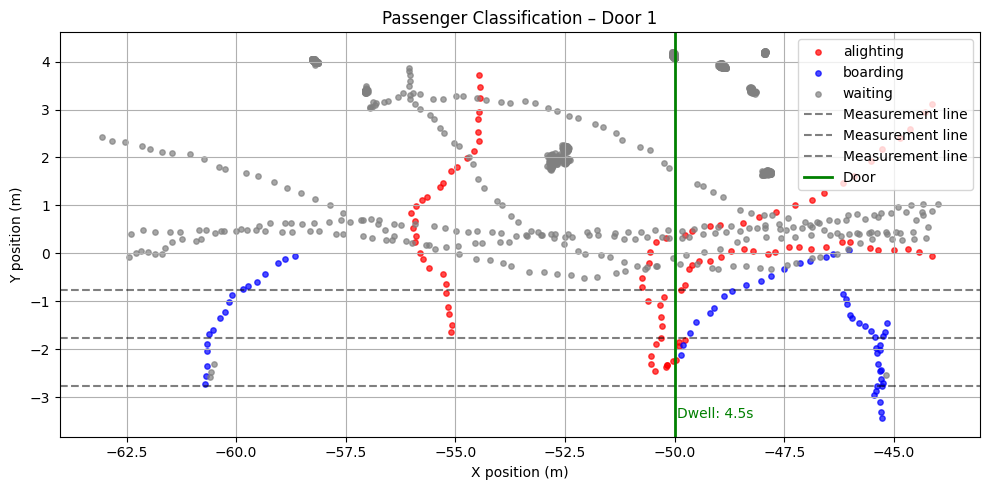

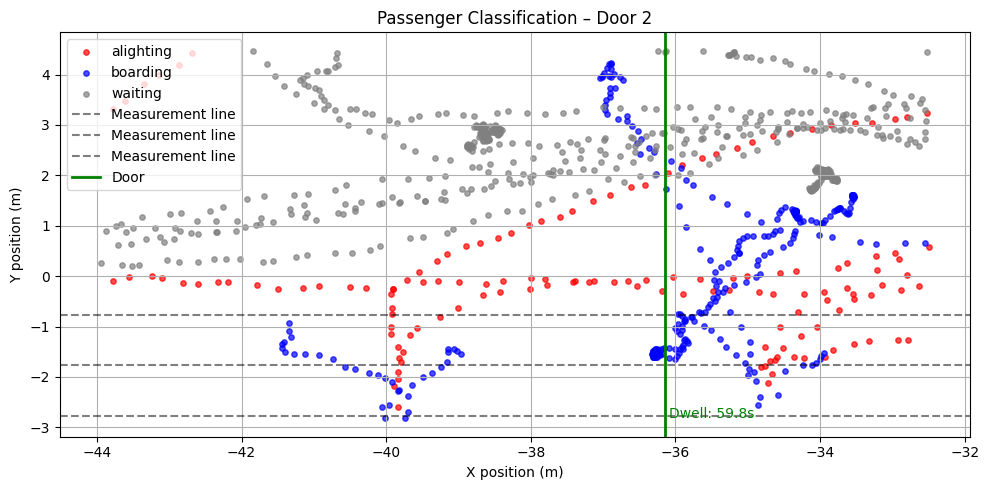

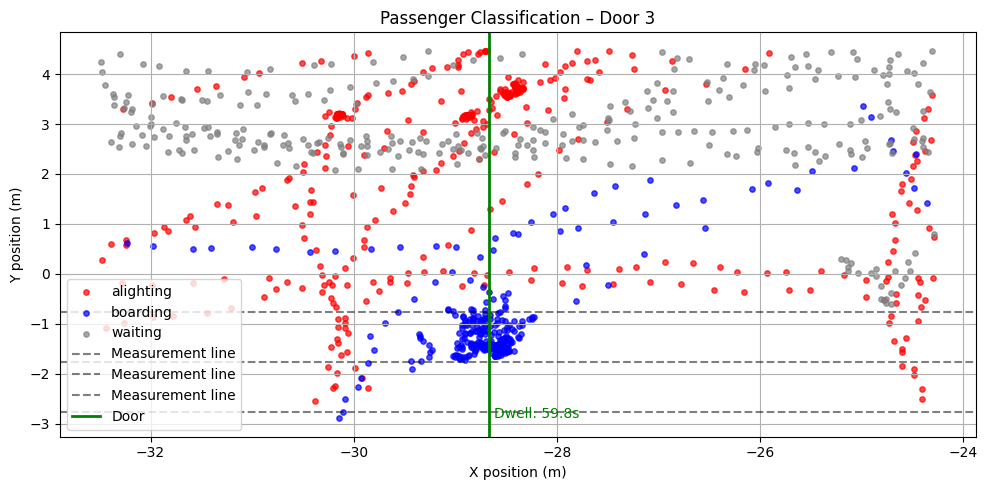

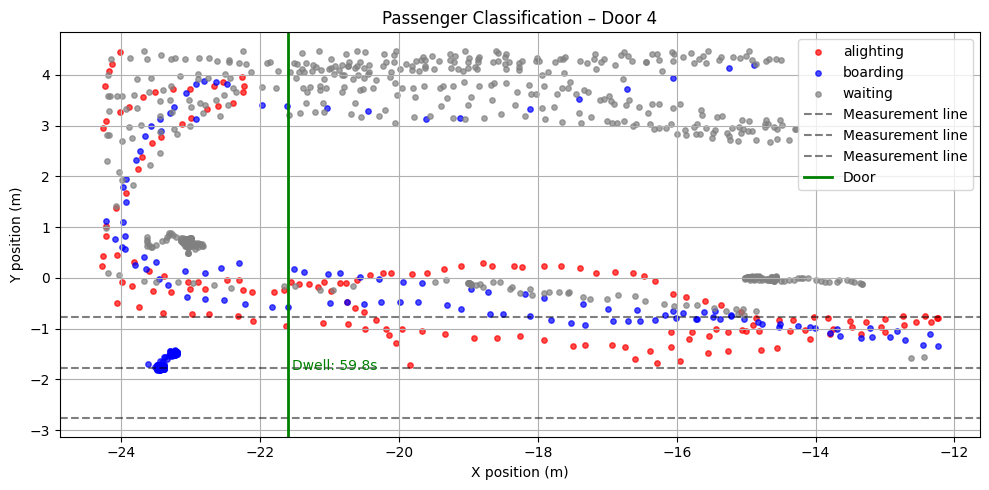

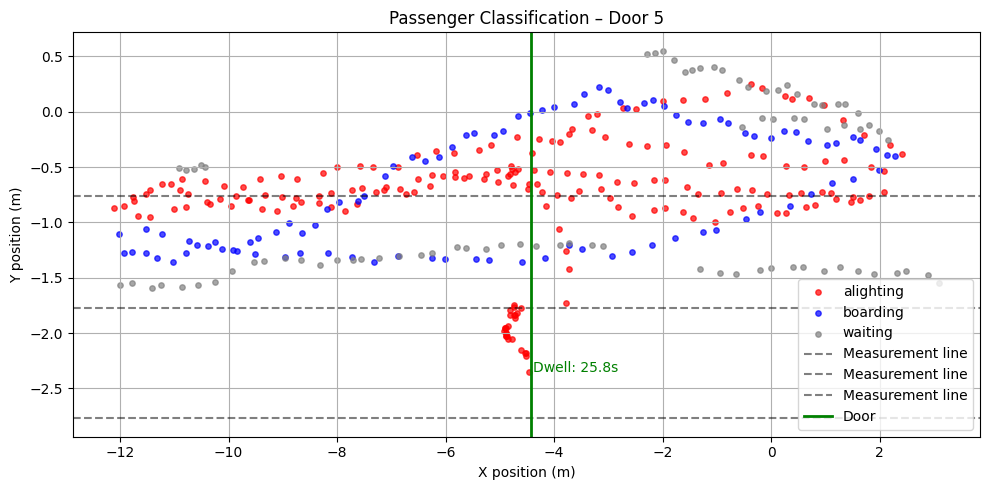

In [55]:
# -----------------------------
# Visualize classification per door with measurement lines
# -----------------------------
colors = {'boarding': 'blue', 'alighting': 'red', 'waiting': 'gray'}
valid_measurement_lines = valid_valleys  # previously defined

for door in sorted(df_train_id_1['door_id'].unique()):
    df_door = df_train_id_1[df_train_id_1['door_id'] == door]

    plt.figure(figsize=(10, 5))

    # Scatter plot of passengers by category
    for cat, group in df_door.groupby('category'):
        plt.scatter(group['x'], group['y'], label=cat, c=colors[cat], s=15, alpha=0.7)

    # Plot measurement lines (horizontal)
    for m_y in valid_measurement_lines:
        plt.axhline(m_y, color='black', linestyle='--', alpha=0.5, label='Measurement line')

    # Door as a vertical line
    door_x = df_door['x'].median()  # or mean, or any fixed x if known
    plt.axvline(door_x, color='green', linestyle='-', linewidth=2, label='Door')

    # Add dwell time annotation
    door_summary = summary_df_train_id_1[summary_df_train_id_1['door_id'] == door]
    dt = door_summary['dwell_time_seconds'].values[0]
    plt.text(door_x + 0.05, min(df_door['y']), f"Dwell: {dt:.1f}s", fontsize=10, color='green')

    plt.xlabel('X position (m)')
    plt.ylabel('Y position (m)')
    plt.title(f'Passenger Classification – Door {door}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [56]:
summary_df_train_id_1

,train_id,door_id,no_of_boarding,no_of_alighting,dwell_time_seconds
0,1,1,4,3,4.50
1,1,2,6,7,59.75
2,1,3,6,12,59.75
3,1,4,5,7,59.75
4,1,5,2,5,25.75


# 3. Crowd Behavior Identification

In [66]:
import pandas as pd
import numpy as np

# -----------------------------
# Parameters
# -----------------------------
FRAME_RATE = 4  # frames per second


# Platform coordinates
platform_y_min = -3.77
platform_y_max = 14.75

# Divide line
y_divide = 4.475

# -----------------------------
# Identify passengers moving toward or away from y = -3.77
# -----------------------------
filtered_ids = []

for pid, group in df.groupby('id'):
    y_start = group.iloc[0]['y']
    y_end = group.iloc[-1]['y']

    dist_start = abs(y_start - platform_y_min)
    dist_end = abs(y_end - platform_y_min)

    if dist_start != dist_end:
        filtered_ids.append(pid)

# Keep only those passengers
df_clean = df[df['id'].isin(filtered_ids)].copy()

# -----------------------------
# Add area column (upper or lower part of platform)
# -----------------------------
df_clean['platform_area'] = np.where(df_clean['y'] > y_divide, 'upper', 'lower')

# -----------------------------
# Focus only on 'lower' platform
# -----------------------------
df_lower = df_clean[df_clean['platform_area'] == 'lower'].copy()

# Add timestamp in seconds for easier bucketing
df_lower['time_sec'] = df_lower['frame'] / FRAME_RATE
df_lower['time_min'] = (df_lower['time_sec'] // 60).astype(int)  # round down to nearest minute

# -----------------------------
# Count number of unique passengers per minute
# -----------------------------
passenger_counts = df_lower.groupby('time_min')['id'].nunique().reset_index()
passenger_counts.columns = ['time_min', 'unique_passengers']

# Basic stats
mean_count = passenger_counts['unique_passengers'].mean()
std_count = passenger_counts['unique_passengers'].std()

# Define crowd levels
def label_crowd(count):
    if count > mean_count + std_count:
        return 'high'
    elif count < mean_count - std_count:
        return 'low'
    else:
        return 'medium'

passenger_counts['crowd_level'] = passenger_counts['unique_passengers'].apply(label_crowd)

import pandas as pd

# -----------------------------
# Define base start time (1:00 AM on any arbitrary date)
# -----------------------------
base_time = pd.Timestamp("2021-07-01 01:00:00")  # adjust date if needed

# -----------------------------
# Extract high and low crowd instances
# -----------------------------
high_crowd_df = passenger_counts[passenger_counts['crowd_level'] == 'high'].nsmallest(5, 'time_min').copy()
low_crowd_df = passenger_counts[passenger_counts['crowd_level'] == 'low'].nsmallest(5, 'time_min').copy()

# -----------------------------
# Convert time_min to actual time
# -----------------------------
high_crowd_df['timestamp'] = high_crowd_df['time_min'].apply(lambda x: base_time + pd.Timedelta(minutes=x))
low_crowd_df['timestamp'] = low_crowd_df['time_min'].apply(lambda x: base_time + pd.Timedelta(minutes=x))

# -----------------------------
# Final Output
# -----------------------------
print("High Crowd Instances:")
print(high_crowd_df[['time_min', 'timestamp', 'unique_passengers']])

print("\nLow Crowd Instances:")
print(low_crowd_df[['time_min', 'timestamp', 'unique_passengers']])


High Crowd Instances:
     time_min           timestamp  unique_passengers
292       347 2021-07-01 06:47:00                129
297       352 2021-07-01 06:52:00                127
307       362 2021-07-01 07:02:00                136
308       363 2021-07-01 07:03:00                121
315       370 2021-07-01 07:10:00                106

Low Crowd Instances:
   time_min           timestamp  unique_passengers
0         3 2021-07-01 01:03:00                  2
1         4 2021-07-01 01:04:00                  1
2         5 2021-07-01 01:05:00                  2
3         6 2021-07-01 01:06:00                  3
4         7 2021-07-01 01:07:00                  5


# 4. Generalized Function Tested on Multiple Time Scenarios

In [105]:
# passenger_analysis.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde


import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use Silhouette Score as an alternative - Gives good results
def detect_optimal_k_silhouette(X, max_k=10):
    scores = []
    for k in range(2, max_k + 1):  # silhouette score not defined for k=1
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
        labels = kmeans.labels_
        score = silhouette_score(X, labels)
        scores.append(score)

    best_k = np.argmax(scores) + 2
    #print(f"Optimal k (Silhouette): {best_k}")
    return best_k




def assign_door_ids(df, optimal_k):
    kmeans = KMeans(n_clusters=optimal_k, random_state=0)
    df['door_id'] = kmeans.fit_predict(df[['x']])
    centers = kmeans.cluster_centers_.flatten()
    sorted_idx = np.argsort(centers)
    label_map = {old: new + 1 for new, old in enumerate(sorted_idx)}
    df['door_id'] = df['door_id'].map(label_map)
    return df, centers


def compute_dynamic_measurement_lines(y_values, static_y=-3.77, dynamic_buffer=4.0):
    kde = gaussian_kde(y_values)
    y_grid = np.linspace(min(y_values), max(y_values), 1000)
    kde_values = kde(y_grid)
    valleys, _ = find_peaks(-kde_values)

    valid_valleys = [y for y in y_grid[valleys] if abs(y - static_y) <= dynamic_buffer]
    valid_valleys += [static_y + i for i in [1.5, 2.5, 3.5]]
    return sorted(valid_valleys)


def classify_passengers(df, measurement_lines):
    boarding_ids, alighting_ids, waiting_ids = set(), set(), set()

    for pid in df['id'].unique():
        p_df = df[df['id'] == pid].sort_values('frame')
        ys = p_df['y'].values

        crossed = False
        for i in range(1, len(ys)):
            prev_y, curr_y = ys[i - 1], ys[i]
            for m_line in measurement_lines:
                if prev_y > m_line and curr_y <= m_line:
                    boarding_ids.add(pid)
                    crossed = True
                    break
                elif prev_y <= m_line and curr_y > m_line:
                    alighting_ids.add(pid)
                    crossed = True
                    break
            if crossed:
                break

        if not crossed:
            waiting_ids.add(pid)

    df['category'] = df['id'].apply(
        lambda x: 'boarding' if x in boarding_ids else ('alighting' if x in alighting_ids else 'waiting')
    )
    return df


def summarize_per_door(df, train_id):
    summary = []
    for door in sorted(df['door_id'].unique()):
        df_door = df[df['door_id'] == door]

        boarding_ids = set(df_door[df_door['category'] == 'boarding']['id'])
        alighting_ids = set(df_door[df_door['category'] == 'alighting']['id'])

        boarding_frames = df_door[df_door['id'].isin(boarding_ids)]['frame']
        alighting_frames = df_door[df_door['id'].isin(alighting_ids)]['frame']

        dwell = np.nan
        if not alighting_frames.empty and not boarding_frames.empty:
            dwell = (boarding_frames.max() - alighting_frames.min()) / 4
            if dwell < 0:
                dwell = np.nan
        elif not boarding_frames.empty:
            dwell = (boarding_frames.max() - boarding_frames.min()) / 4
        elif not alighting_frames.empty:
            dwell = (alighting_frames.max() - alighting_frames.min()) / 4

        summary.append({
            'train_id': train_id,
            'door_id': door,
            'no_of_boarding': len(boarding_ids),
            'no_of_alighting': len(alighting_ids),
            'dwell_time_seconds': dwell
        })
    return pd.DataFrame(summary)


def process_all_trains(df_all, train_df, edge_threshold_y):
    all_summaries = []
    for train_id in train_df['train_id'].unique():
        train_info = train_df[train_df['train_id'] == train_id].iloc[0]
        start_frame, end_frame = train_info['start_frame'], train_info['end_frame']
        df = df_all[(df_all['frame'] >= start_frame) & (df_all['frame'] < end_frame)].copy()

        # Detect doors
        edge_df = df[df['y'] < edge_threshold_y].copy()
        optimal_k = detect_optimal_k_silhouette(edge_df[['x']].to_numpy())
        df, _ = assign_door_ids(df, optimal_k)

        # Classify
        measurement_lines = compute_dynamic_measurement_lines(df['y'].values)
        df = classify_passengers(df, measurement_lines)

        # Summarize
        summary_df = summarize_per_door(df, train_id)
        all_summaries.append(summary_df)

    return pd.concat(all_summaries, ignore_index=True)


## 1. High Crowd Period: 6:30 AM to 10:00 AM

In [106]:
# lets run the code for  heavily crowded time frame is morning 6.50 to 10 am

import pandas as pd
import numpy as np

# -----------------------------
# Parameters
# -----------------------------
FRAME_RATE = 4  # frames per second


# Platform coordinates
platform_y_min = -3.77
platform_y_max = 14.75

# Divide line
y_divide = 4.475

# Time range (6.5 to 10)
start_hour = 6.5
end_hour = 10
start_sec = start_hour * 3600
end_sec = end_hour * 3600

start_frame = int(start_sec * FRAME_RATE)
end_frame = int(end_sec * FRAME_RATE)

df_time = df[(df['frame'] >= start_frame) & (df['frame'] < end_frame)]

# -----------------------------
# Identify passengers moving toward or away from y = -3.77
# -----------------------------
filtered_ids = []

for pid, group in df_time.groupby('id'):
    y_start = group.iloc[0]['y']
    y_end = group.iloc[-1]['y']

    dist_start = abs(y_start - platform_y_min)
    dist_end = abs(y_end - platform_y_min)

    if dist_start != dist_end:
        filtered_ids.append(pid)

# Keep only those passengers
df_clean = df_time[df_time['id'].isin(filtered_ids)].copy()

# -----------------------------
# Add area column (upper or lower part of platform)
# -----------------------------
df_clean['platform_area'] = np.where(df_clean['y'] > y_divide, 'upper', 'lower')


# -----------------------------
# Parameters
# -----------------------------
platform_edge_y = -3.77
edge_threshold_y = -2.27 # consider as 'near edge'
window_size_frames = 240  # 1 minute window (1 min * 60 sec * 4 fps)
passenger_threshold = 20  # adjust depending on your data

# -----------------------------
# Load cleaned data
# -----------------------------
# df_clean has clean data

# Only lower platform area
df_lower = df_clean[df_clean['platform_area'] == 'lower'].copy()

# -----------------------------
# Step 1: Identify train instances
# -----------------------------
min_frame = df_lower['frame'].min()
max_frame = df_lower['frame'].max()

train_instances = []
current_train_id = 1

for start in range(min_frame, max_frame, window_size_frames):
    end = start + window_size_frames
    window_df = df_lower[(df_lower['frame'] >= start) & (df_lower['frame'] < end)]
    edge_df = window_df[window_df['y'] < edge_threshold_y]

    num_passengers = edge_df['id'].nunique()

    if num_passengers >= passenger_threshold:
        train_instances.append({
            'train_id': current_train_id,
            'start_frame': start,
            'end_frame': end
        })
        current_train_id += 1

train_df = pd.DataFrame(train_instances)

# Set edge threshold
edge_threshold_y = -2.27  # Or any value based on your platform geometry

# This line filters the pedestrian data to keep only those below the edge_threshold_y value.
# These are assumed to be close to or crossing the platform edge, where passengers typically interact with train doors (boarding/alighting).
#  This edge_df is then used to detect clusters (doors) using KMeans.

summary_df = process_all_trains(df_lower, train_df, edge_threshold_y)
# -----------------------------
# Step 1: Load or clean the data
# -----------------------------
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Assuming your summary dataframe is already named `summary_df_for_modelling_train_id_1`
df_for_modelling = summary_df.copy()

# Remove rows with NaN dwell time
df_for_modelling = df_for_modelling.dropna(subset=['dwell_time_seconds'])

# Optional: Remove rows with zero activity
df_for_modelling = df_for_modelling[(df_for_modelling['no_of_boarding'] > 0) | (df_for_modelling['no_of_alighting'] > 0)]

# -----------------------------
# Step 2: Train-test split
# -----------------------------
X = df_for_modelling[['no_of_boarding', 'no_of_alighting']]
y = df_for_modelling['dwell_time_seconds']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# -----------------------------
# Step 3: Train a regression model
# -----------------------------
model = LinearRegression()
model.fit(X_train, y_train)

# -----------------------------
# Step 4: Evaluate performance
# -----------------------------
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the number of unique train instances
print("Number of train instances:", summary_df["train_id"].nunique())
# Print the shape of the summary dataframe (rows, columns)
print("Number of total observations:", summary_df.shape[0])
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# -----------------------------
# Step 6: Model coefficients
# -----------------------------
print("\nRegression equation:")
print(f"Dwell Time = {model.intercept_:.2f} + "
      f"{model.coef_[0]:.2f} * no_of_boarding + "
      f"{model.coef_[1]:.2f} * no_of_alighting")




Number of train instances: 23
Number of total observations: 221
Mean Absolute Error (MAE): 13.47
Root Mean Squared Error (RMSE): 16.00

Regression equation:
Dwell Time = 24.45 + 0.58 * no_of_boarding + 0.76 * no_of_alighting


# 3. Low Crowd Period: 1:00 AM to 4:30 AM

In [107]:
# -----------------------------
# Parameters
# -----------------------------
FRAME_RATE = 4  # frames per second


# Platform coordinates
platform_y_min = -3.77
platform_y_max = 14.75

# Divide line
y_divide = 4.475

start_hour = 1
end_hour = 4.5
start_sec = start_hour * 3600
end_sec = end_hour * 3600

start_frame = int(start_sec * FRAME_RATE)
end_frame = int(end_sec * FRAME_RATE)

df_time = df[(df['frame'] >= start_frame) & (df['frame'] < end_frame)]

# -----------------------------
# Identify passengers moving toward or away from y = -3.77
# -----------------------------
filtered_ids = []

for pid, group in df_time.groupby('id'):
    y_start = group.iloc[0]['y']
    y_end = group.iloc[-1]['y']

    dist_start = abs(y_start - platform_y_min)
    dist_end = abs(y_end - platform_y_min)

    if dist_start != dist_end:
        filtered_ids.append(pid)

# Keep only those passengers
df_clean = df_time[df_time['id'].isin(filtered_ids)].copy()

# -----------------------------
# Add area column (upper or lower part of platform)
# -----------------------------
df_clean['platform_area'] = np.where(df_clean['y'] > y_divide, 'upper', 'lower')


# -----------------------------
# Parameters
# -----------------------------
platform_edge_y = -3.77
edge_threshold_y = -2.27 # consider as 'near edge'
window_size_frames = 240  # 1 minute window (1 min * 60 sec * 4 fps)
passenger_threshold = 5 # adjust depending on your data

# -----------------------------
# Load cleaned data
# -----------------------------
# df_clean has clean data

# Only lower platform area
df_lower = df_clean[df_clean['platform_area'] == 'lower'].copy()

# -----------------------------
# Step 1: Identify train instances
# -----------------------------
min_frame = df_lower['frame'].min()
max_frame = df_lower['frame'].max()

train_instances = []
current_train_id = 1

for start in range(min_frame, max_frame, window_size_frames):
    end = start + window_size_frames
    window_df = df_lower[(df_lower['frame'] >= start) & (df_lower['frame'] < end)]
    edge_df = window_df[window_df['y'] < edge_threshold_y]

    num_passengers = edge_df['id'].nunique()

    if num_passengers >= passenger_threshold:
        train_instances.append({
            'train_id': current_train_id,
            'start_frame': start,
            'end_frame': end
        })
        current_train_id += 1

train_df = pd.DataFrame(train_instances)
# Set edge threshold
edge_threshold_y = -2.27  # Or any value based on your platform geometry
# This line filters the pedestrian data to keep only those below the edge_threshold_y value.
# These are assumed to be close to or crossing the platform edge, where passengers typically interact with train doors (boarding/alighting).
#  This edge_df is then used to detect clusters (doors) using KMeans.

# Process all trains and generate summary
summary_df = process_all_trains(df_lower, train_df, edge_threshold_y)
# -----------------------------
# Step 1: Load or clean the data
# -----------------------------

# Assuming your summary dataframe is already named `summary_df_for_modelling_train_id_1`
df_for_modelling = summary_df.copy()

# Remove rows with NaN dwell time
df_for_modelling = df_for_modelling.dropna(subset=['dwell_time_seconds'])

# Optional: Remove rows with zero activity
df_for_modelling = df_for_modelling[(df_for_modelling['no_of_boarding'] > 0) | (df_for_modelling['no_of_alighting'] > 0)]

# -----------------------------
# Step 2: Train-test split
# -----------------------------
X = df_for_modelling[['no_of_boarding', 'no_of_alighting']]
y = df_for_modelling['dwell_time_seconds']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# -----------------------------
# Step 3: Train a regression model
# -----------------------------
model = LinearRegression()
model.fit(X_train, y_train)

# -----------------------------
# Step 4: Evaluate performance
# -----------------------------
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# Print the number of unique train instances
print("Number of train instances:", summary_df["train_id"].nunique())

# Print the shape of the summary dataframe (rows, columns)
print("Number of total observations:", summary_df.shape[0])

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


# -----------------------------
# Step 6: Model coefficients
# -----------------------------
print("\nRegression equation:")
print(f"Dwell Time = {model.intercept_:.2f} + "
      f"{model.coef_[0]:.2f} * no_of_boarding + "
      f"{model.coef_[1]:.2f} * no_of_alighting")




Number of train instances: 11
Number of total observations: 68
Mean Absolute Error (MAE): 14.26
Root Mean Squared Error (RMSE): 16.58

Regression equation:
Dwell Time = 15.31 + 0.44 * no_of_boarding + 2.46 * no_of_alighting


# 2. High Crowd Period: 4:30 PM to 7:00 PM

In [108]:
  # heavy crowd evening 4.30 pm to 7 pm

import pandas as pd
import numpy as np

# -----------------------------
# Parameters
# -----------------------------
FRAME_RATE = 4  # frames per second


# Platform coordinates
platform_y_min = -3.77
platform_y_max = 14.75

# Divide line
y_divide = 4.475

start_hour = 16.5
end_hour = 19
start_sec = start_hour * 3600
end_sec = end_hour * 3600

start_frame = int(start_sec * FRAME_RATE)
end_frame = int(end_sec * FRAME_RATE)

df_time = df[(df['frame'] >= start_frame) & (df['frame'] < end_frame)]

# -----------------------------
# Identify passengers moving toward or away from y = -3.77
# -----------------------------
filtered_ids = []

for pid, group in df_time.groupby('id'):
    y_start = group.iloc[0]['y']
    y_end = group.iloc[-1]['y']

    dist_start = abs(y_start - platform_y_min)
    dist_end = abs(y_end - platform_y_min)

    if dist_start != dist_end:
        filtered_ids.append(pid)

# Keep only those passengers
df_clean = df_time[df_time['id'].isin(filtered_ids)].copy()

# -----------------------------
# Add area column (upper or lower part of platform)
# -----------------------------
df_clean['platform_area'] = np.where(df_clean['y'] > y_divide, 'upper', 'lower')


# -----------------------------
# Parameters
# -----------------------------
platform_edge_y = -3.77
edge_threshold_y = -2.27 # consider as 'near edge'
window_size_frames = 240  # 1 minute window (1 min * 60 sec * 4 fps)
passenger_threshold = 20  # adjust depending on your data

# -----------------------------
# Load cleaned data
# -----------------------------
# df_clean has clean data

# Only lower platform area
df_lower = df_clean[df_clean['platform_area'] == 'lower'].copy()

# -----------------------------
# Step 1: Identify train instances
# -----------------------------
min_frame = df_lower['frame'].min()
max_frame = df_lower['frame'].max()

train_instances = []
current_train_id = 1

for start in range(min_frame, max_frame, window_size_frames):
    end = start + window_size_frames
    window_df = df_lower[(df_lower['frame'] >= start) & (df_lower['frame'] < end)]
    edge_df = window_df[window_df['y'] < edge_threshold_y]

    num_passengers = edge_df['id'].nunique()

    if num_passengers >= passenger_threshold:
        train_instances.append({
            'train_id': current_train_id,
            'start_frame': start,
            'end_frame': end
        })
        current_train_id += 1

train_df = pd.DataFrame(train_instances)


# Set edge threshold
edge_threshold_y = -2.27  # Or any value based on your platform geometry

# This line filters the pedestrian data to keep only those below the edge_threshold_y value.
# These are assumed to be close to or crossing the platform edge, where passengers typically interact with train doors (boarding/alighting).
#  This edge_df is then used to detect clusters (doors) using KMeans.

# Process all trains and generate summary
summary_df = process_all_trains(df_lower, train_df, edge_threshold_y)
# -----------------------------
# Step 1: Load or clean the data
# -----------------------------
df_for_modelling = summary_df.copy()

# Remove rows with NaN dwell time
df_for_modelling = df_for_modelling.dropna(subset=['dwell_time_seconds'])

# Optional: Remove rows with zero activity
df_for_modelling = df_for_modelling[(df_for_modelling['no_of_boarding'] > 0) | (df_for_modelling['no_of_alighting'] > 0)]

# -----------------------------
# Step 2: Train-test split
# -----------------------------
X = df_for_modelling[['no_of_boarding', 'no_of_alighting']]
y = df_for_modelling['dwell_time_seconds']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# -----------------------------
# Step 3: Train a regression model
# -----------------------------
model = LinearRegression()
model.fit(X_train, y_train)

# -----------------------------
# Step 4: Evaluate performance
# -----------------------------
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the number of unique train instances
print("Number of train instances:", summary_df["train_id"].nunique())

# Print the shape of the summary dataframe (rows, columns)
print("Number of total observations:", summary_df.shape[0])

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


# -----------------------------
# Step 6: Model coefficients
# -----------------------------
print("\nRegression equation:")
print(f"Dwell Time = {model.intercept_:.2f} + "
      f"{model.coef_[0]:.2f} * no_of_boarding + "
      f"{model.coef_[1]:.2f} * no_of_alighting")




Number of train instances: 21
Number of total observations: 204
Mean Absolute Error (MAE): 15.36
Root Mean Squared Error (RMSE): 17.43

Regression equation:
Dwell Time = 18.73 + 1.04 * no_of_boarding + 0.72 * no_of_alighting
